In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPool2D, Flatten,Dense,Dropout,BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
from tensorflow.keras.applications import VGG16, InceptionResNetV2
from keras import regularizers
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,10)

In [2]:
train_dir = "../train" #passing the path with training images
test_dir = "../test"   #passing the path with testing images

In [3]:
img_size = 48

In [4]:
train_datagen = ImageDataGenerator(#rotation_range = 180,
                                         width_shift_range = 0.1,
                                         height_shift_range = 0.1,
                                         horizontal_flip = True,
                                         rescale = 1./255,
                                         #zoom_range = 0.2,
                                         validation_split = 0.2
                                        )
validation_datagen = ImageDataGenerator(rescale = 1./255,
                                         validation_split = 0.2)

In [5]:
train_generator = train_datagen.flow_from_directory(directory = train_dir,
                                                    target_size = (img_size,img_size),
                                                    batch_size = 64,
                                                    color_mode = "grayscale",
                                                    class_mode = "categorical",
                                                    subset = "training"
                                                   )
validation_generator = validation_datagen.flow_from_directory( directory = test_dir,
                                                              target_size = (img_size,img_size),
                                                              batch_size = 64,
                                                              color_mode = "grayscale",
                                                              class_mode = "categorical",
                                                              subset = "validation"
                                                                                         )

Found 22968 images belonging to 7 classes.
Found 1432 images belonging to 7 classes.


In [6]:
X_train, y_train = next(train_generator)
X_test, y_test = next(validation_generator)

In [7]:
len(train_generator)

359

In [8]:
X_train.shape

(64, 48, 48, 1)

In [9]:
y_train.shape

(64, 7)

In [10]:
X_test.shape

(64, 48, 48, 1)

In [11]:
y_test.shape

(64, 7)

In [12]:
class_names = train_generator.class_indices

class_names_swap = {v: k for k, v in class_names.items()}
print(class_names_swap)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


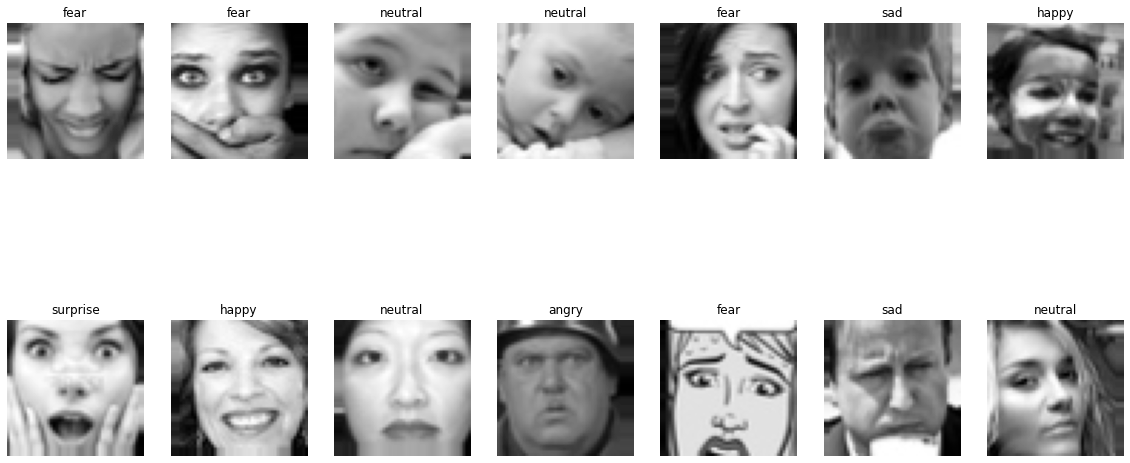

In [13]:
import random
import cv2
import matplotlib.pyplot as plt
import numpy as np 

r = random.sample(range(X_train.shape[0]), 14)
for i in range(14):
    plt.subplot(2, 7, i+1)
    plt.imshow(X_train[r[i]],'gray')
    plt.title(class_names_swap[np.argmax(y_train[r[i]])])
    plt.axis("off")    

In [14]:
from sklearn.utils import class_weight 
import numpy as np

class_weights = class_weight.compute_class_weight(
            class_weight = 'balanced',
            classes = np.unique(train_generator.classes), 
            y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))
# model.fit_generator(..., class_weight=train_class_weights)

In [15]:
train_class_weights

{0: 1.0266404434114071,
 1: 9.401555464592715,
 2: 1.0009587727708533,
 3: 0.5684585684585685,
 4: 0.826068191627104,
 5: 0.8491570541259982,
 6: 1.2933160650937552}

In [16]:
class_names_swap

{0: 'angry',
 1: 'disgust',
 2: 'fear',
 3: 'happy',
 4: 'neutral',
 5: 'sad',
 6: 'surprise'}

In [17]:
def identity_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [18]:
def convolutional_block(x, filter):
    # copy tensor to variable called x_skip
    x_skip = x
    # Layer 1
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same', strides = (2,2))(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Activation('relu')(x)
    # Layer 2
    x = tf.keras.layers.Conv2D(filter, (3,3), padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    # Processing Residue with conv(1,1)
    x_skip = tf.keras.layers.Conv2D(filter, (1,1), strides = (2,2))(x_skip)
    # Add Residue
    x = tf.keras.layers.Add()([x, x_skip])     
    x = tf.keras.layers.Activation('relu')(x)
    return x

In [19]:
def model_four(shape = (32, 32, 3), classes = 10):
    x_input = tf.keras.layers.Input(shape)
    x = tf.keras.layers.ZeroPadding2D((3, 3))(x_input)
    x = tf.keras.layers.Conv2D(64, kernel_size=7, strides=2, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=3, strides=2, padding='same')(x)
    
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = identity_block(x, 64)
    x = convolutional_block(x, 128)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = identity_block(x, 128)
    x = convolutional_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = identity_block(x, 256)
    x = convolutional_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = identity_block(x, 512)
    x = tf.keras.layers.Dropout( 0.25)(x)
    x = identity_block(x, 512)
    
    x = tf.keras.layers.AveragePooling2D((2,2), padding = 'same')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation = 'relu')(x)
    x = tf.keras.layers.Dense(256, activation = 'relu')(x)
    x = tf.keras.layers.Dense(classes, activation = 'softmax')(x)
    model = tf.keras.models.Model(inputs = x_input, outputs = x, name = "model_two")
    return model

In [20]:
model = model_four(shape = (48, 48, 1), classes = 7)

epochs = 100
batch_size = 64
model.summary()

Model: "model_two"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 48, 48, 1)]  0           []                               
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 54, 54, 1)   0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 27, 27, 64)   3200        ['zero_padding2d[0][0]']         
                                                                                                  
 batch_normalization (BatchNorm  (None, 27, 27, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                               

                                                                                                  
 activation_8 (Activation)      (None, 7, 7, 128)    0           ['add_3[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 7, 7, 128)    0           ['activation_8[0][0]']           
                                                                                                  
 conv2d_10 (Conv2D)             (None, 7, 7, 128)    147584      ['dropout[0][0]']                
                                                                                                  
 batch_normalization_9 (BatchNo  (None, 7, 7, 128)   512         ['conv2d_10[0][0]']              
 rmalization)                                                                                     
                                                                                                  
 activatio

 ormalization)                                                                                    
                                                                                                  
 add_8 (Add)                    (None, 7, 7, 128)    0           ['batch_normalization_18[0][0]', 
                                                                  'activation_16[0][0]']          
                                                                                                  
 activation_18 (Activation)     (None, 7, 7, 128)    0           ['add_8[0][0]']                  
                                                                                                  
 conv2d_20 (Conv2D)             (None, 4, 4, 256)    295168      ['activation_18[0][0]']          
                                                                                                  
 batch_normalization_19 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_20[0][0]']              
 ormalizat

                                                                                                  
 activation_27 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_27[0][0]'] 
                                                                                                  
 conv2d_30 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_27[0][0]']          
                                                                                                  
 batch_normalization_28 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_30[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_13 (Add)                   (None, 4, 4, 256)    0           ['batch_normalization_28[0][0]', 
                                                                  'activation_26[0][0]']          
          

 conv2d_39 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_36[0][0]']          
                                                                                                  
 batch_normalization_37 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_39[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_37 (Activation)     (None, 4, 4, 256)    0           ['batch_normalization_37[0][0]'] 
                                                                                                  
 conv2d_40 (Conv2D)             (None, 4, 4, 256)    590080      ['activation_37[0][0]']          
                                                                                                  
 batch_normalization_38 (BatchN  (None, 4, 4, 256)   1024        ['conv2d_40[0][0]']              
 ormalizat

                                                                                                  
 add_22 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_46[0][0]', 
                                                                  'dropout_3[0][0]']              
                                                                                                  
 activation_46 (Activation)     (None, 2, 2, 512)    0           ['add_22[0][0]']                 
                                                                                                  
 conv2d_50 (Conv2D)             (None, 2, 2, 512)    2359808     ['activation_46[0][0]']          
                                                                                                  
 batch_normalization_47 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_50[0][0]']              
 ormalization)                                                                                    
          

 batch_normalization_56 (BatchN  (None, 2, 2, 512)   2048        ['conv2d_59[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 add_27 (Add)                   (None, 2, 2, 512)    0           ['batch_normalization_56[0][0]', 
                                                                  'activation_54[0][0]']          
                                                                                                  
 activation_56 (Activation)     (None, 2, 2, 512)    0           ['add_27[0][0]']                 
                                                                                                  
 dropout_4 (Dropout)            (None, 2, 2, 512)    0           ['activation_56[0][0]']          
                                                                                                  
 conv2d_60

In [21]:
model.compile(
    optimizer = 'adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy']
  )

In [22]:
import scipy.integrate

import scipy.special
import scipy

history = model.fit(x = train_generator,epochs = epochs,batch_size=batch_size,validation_data = validation_generator, class_weight=train_class_weights)

Epoch 1/100
359/359 [==============================] - 131s 330ms/step - loss: 2.0917 - accuracy: 0.1610 - val_loss: 1.9486 - val_accuracy: 0.1718
Epoch 2/100
359/359 [==============================] - 120s 334ms/step - loss: 1.8806 - accuracy: 0.1835 - val_loss: 1.8591 - val_accuracy: 0.2716
Epoch 3/100
359/359 [==============================] - 122s 340ms/step - loss: 1.8366 - accuracy: 0.2130 - val_loss: 2.6361 - val_accuracy: 0.1180
Epoch 4/100
359/359 [==============================] - 122s 341ms/step - loss: 1.8209 - accuracy: 0.2067 - val_loss: 2.3879 - val_accuracy: 0.1390
Epoch 5/100
359/359 [==============================] - 123s 344ms/step - loss: 1.7943 - accuracy: 0.2345 - val_loss: 2.3099 - val_accuracy: 0.1341
Epoch 6/100
359/359 [==============================] - 124s 344ms/step - loss: 1.7590 - accuracy: 0.2872 - val_loss: 1.8920 - val_accuracy: 0.2109
Epoch 7/100
359/359 [==============================] - 124s 344ms/step - loss: 1.7429 - accuracy: 0.2786 - val_loss: 1

359/359 [==============================] - 317s 882ms/step - loss: 1.0283 - accuracy: 0.5799 - val_loss: 1.1958 - val_accuracy: 0.5594
Epoch 57/100
359/359 [==============================] - 317s 882ms/step - loss: 1.0145 - accuracy: 0.5854 - val_loss: 1.2937 - val_accuracy: 0.5203
Epoch 58/100
359/359 [==============================] - 317s 882ms/step - loss: 1.0184 - accuracy: 0.5867 - val_loss: 1.1858 - val_accuracy: 0.5733
Epoch 59/100
359/359 [==============================] - 317s 882ms/step - loss: 0.9947 - accuracy: 0.5940 - val_loss: 1.2504 - val_accuracy: 0.5398
Epoch 60/100
359/359 [==============================] - 317s 882ms/step - loss: 0.9913 - accuracy: 0.5933 - val_loss: 1.1770 - val_accuracy: 0.5531
Epoch 61/100
359/359 [==============================] - 317s 882ms/step - loss: 0.9650 - accuracy: 0.6018 - val_loss: 1.3401 - val_accuracy: 0.5133
Epoch 62/100
359/359 [==============================] - 317s 882ms/step - loss: 0.9735 - accuracy: 0.6048 - val_loss: 1.1371 

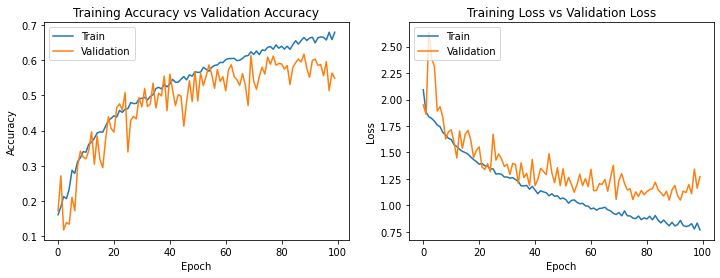

In [23]:
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
fig.set_size_inches(12,4)

ax[0].plot(history.history['accuracy'])
ax[0].plot(history.history['val_accuracy'])
ax[0].set_title('Training Accuracy vs Validation Accuracy')
ax[0].set_ylabel('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].legend(['Train', 'Validation'], loc='upper left')

ax[1].plot(history.history['loss'])
ax[1].plot(history.history['val_loss'])
ax[1].set_title('Training Loss vs Validation Loss')
ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epoch')
ax[1].legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [24]:
model.save('deeperdropout41_100_model.h5')
model.save_weights('deeperdropout41_100_weights.h5')

In [25]:
train_loss, train_acc = model.evaluate(train_generator)
test_loss, test_acc   = model.evaluate(validation_generator)
print("final train accuracy = {:.2f} , validation accuracy = {:.2f}".format(train_acc*100, test_acc*100))

23/23 [==============================] - 5s 221ms/step - loss: 1.2712 - accuracy: 0.5489
final train accuracy = 62.21 , validation accuracy = 54.89


23/23 [==============================] - 6s 229ms/step
Confusion Matrix
[[27  6 35 34 24 39 26]
 [ 4  0  8  3  4  3  0]
 [37  4 26 27 26 52 32]
 [56  5 60 52 45 90 46]
 [41  3 50 37 31 53 31]
 [37  7 48 39 32 53 33]
 [30  4 31 28 25 33 15]]
Classification Report
              precision    recall  f1-score   support

       angry       0.12      0.14      0.13       191
     disgust       0.00      0.00      0.00        22
        fear       0.10      0.13      0.11       204
       happy       0.24      0.15      0.18       354
     neutral       0.17      0.13      0.14       246
         sad       0.16      0.21      0.19       249
    surprise       0.08      0.09      0.09       166

    accuracy                           0.14      1432
   macro avg       0.12      0.12      0.12      1432
weighted avg       0.15      0.14      0.14      1432



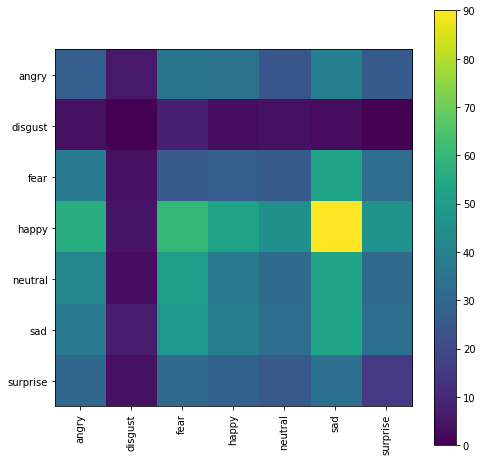

In [26]:
y_pred = model.predict(validation_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = validation_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)

359/359 [==============================] - 80s 223ms/step
Confusion Matrix
[[ 449   99  503  529  425  822  369]
 [  38    9   48   65   43   96   50]
 [ 459   80  496  550  456  860  377]
 [ 839  130  915  965  744 1496  683]
 [ 598  102  612  629  521 1061  449]
 [ 579  119  601  642  496  993  434]
 [ 409   60  423  436  294  636  279]]
Classification Report
              precision    recall  f1-score   support

       angry       0.13      0.14      0.14      3196
     disgust       0.02      0.03      0.02       349
        fear       0.14      0.15      0.14      3278
       happy       0.25      0.17      0.20      5772
     neutral       0.17      0.13      0.15      3972
         sad       0.17      0.26      0.20      3864
    surprise       0.11      0.11      0.11      2537

    accuracy                           0.16     22968
   macro avg       0.14      0.14      0.14     22968
weighted avg       0.17      0.16      0.16     22968



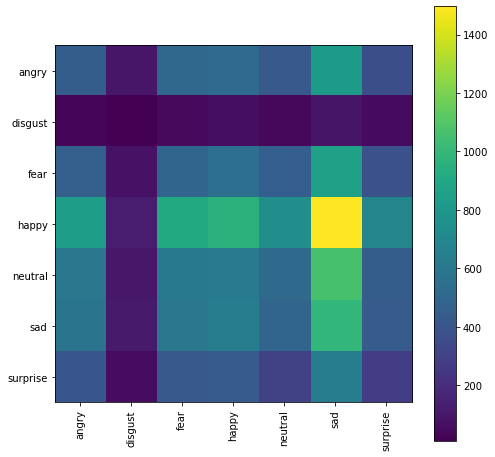

In [27]:
y_pred = model.predict(train_generator)
y_pred = np.argmax(y_pred, axis=1)
class_labels = train_generator.class_indices
class_labels = {v:k for k,v in class_labels.items()}

from sklearn.metrics import classification_report, confusion_matrix
cm_train = confusion_matrix(train_generator.classes, y_pred)
print('Confusion Matrix')
print(cm_train)
print('Classification Report')
target_names = list(class_labels.values())
print(classification_report(train_generator.classes, y_pred, target_names=target_names))

plt.figure(figsize=(8,8))
plt.imshow(cm_train, interpolation='nearest')
plt.colorbar()
tick_mark = np.arange(len(target_names))
_ = plt.xticks(tick_mark, target_names, rotation=90)
_ = plt.yticks(tick_mark, target_names)